In [1]:
# initial setup
%run "../../../common/0_notebooks_base_setup.py"

/Users/csuarezgurruchaga/Desktop/Digital-House/clase_20/dsad_2021/common
default checking
Running command `conda list`... ok
jupyterlab=2.2.6 already installed
pandas=1.1.5 already installed
bokeh=2.2.3 already installed
seaborn=0.11.0 already installed
matplotlib=3.3.2 already installed
ipywidgets=7.5.1 already installed
pytest=6.2.1 already installed
chardet=4.0.0 already installed
psutil=5.7.2 already installed
scipy=1.5.2 already installed
statsmodels=0.12.1 already installed
scikit-learn=0.23.2 already installed
xlrd=2.0.1 already installed
Running command `conda install --yes nltk=3.5.0`... ok
Solving environment: ...working... done

# All requested packages already installed.


unidecode=1.1.1 already installed
pydotplus=2.0.2 already installed
pandas-datareader=0.9.0 already installed
flask=1.1.2 already installed


---

<img src='../../../common/logo_DH.png' align='left' width=35%/>


# Aprendizaje no supervisado

<a id="section_toc"></a> 
## Tabla de Contenidos

<a href="#section_intro">Introducción</a>

<a href="#section_data">Dataset</a>

<a href="#section_cluster">Clustering</a>

<a href="#section_pca">Reducción de la Dimensionalidad</a>

<a href="#section_resumen">En resumen</a>

---

<a id="section_intro"></a>
##  Introducción

[volver a TOC](#section_toc)


Ya hemos visto ejemplos sencillos de problemas de aprendizaje supervisado, donde buscamos predecir a partir de ciertas _features_ una variable _target_ que puede ser continua (problemas de regresión) o categórica (clasificación). Tuvimos un primer contacto con la biblioteca Scikit-Learn, la herrramienta por excelencia para trabajar con _machine learning_ en Python.

Comencemos repasando en qué consiste este otro tipo de <i>machine learning</i>.

El aprendizaje no supervisado **se caracteriza por prescindir de una variable _target_.** El foco está puesto en descubrir patrones o estructuras subyacentes en la información que nos permitan generar _insights_ relevantes en una estructura de datos que, a priori, no son evidentes. 

Dentro del aprendizaje no supervisado, se engloban las técnicas de **_clustering_** y las de **reducción de la dimensionalidad**.

Primero importamos las librerías necesarias para trabajar con datos y visualizar:

In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

<a id="section_data"></a>

### Dataset

[volver a TOC](#section_toc)


Veremos un ejemplo de cada técnica a partir del dataset de [Iris](https://es.wikipedia.org/wiki/Conjunto_de_datos_flor_iris), sobre el cual ya estuvimos trabajando anteriormente para entrenar nuestro primer modelo de clasificación.

<img src="https://shahinrostami.com/images/ml-with-kaggle/iris-2338142_960_720-1.jpg">
<center><i>La flor iris</i></center>

Podemos cargar el dataset desde la librería Seaborn:

In [3]:
iris = sns.load_dataset('iris')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


Inspeccionamos la tabla y describimos la información:

In [4]:
iris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [5]:
iris.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


Visualizamos los datos:

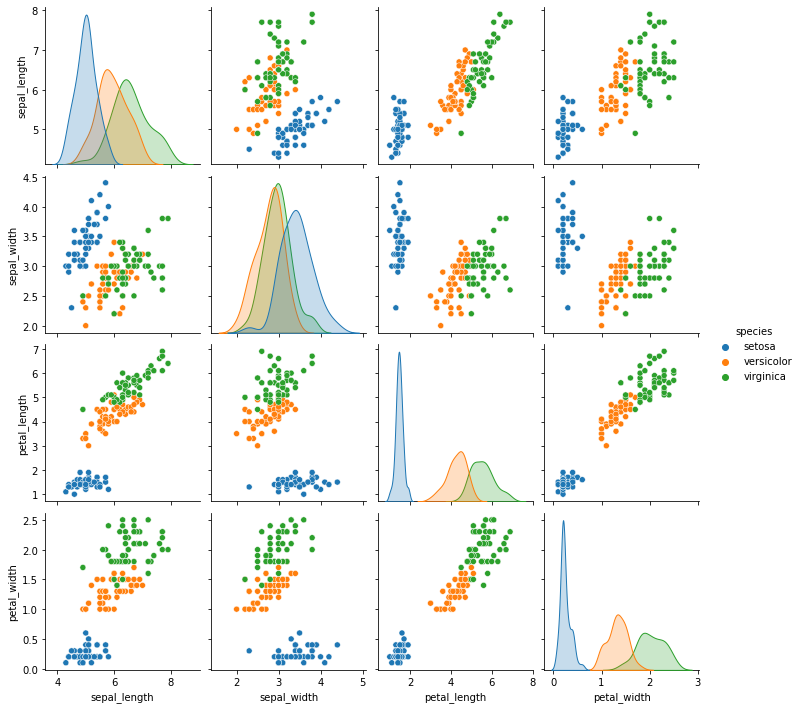

In [6]:
sns.pairplot(iris, hue='species');

<div id="caja10" style="float:left;width: 100%;">
  <div style="float:left;width: 15%;"><img src="../../../common/icons/para_seguir_pensando.png" style="align:left"/> </div>
  <br>
  <br>
  <div style="float:left;width: 85%;"><label><b>¿Qué apreciamos en estos gráficos? ¿Existen patrones relevantes que surjan a simple vista? ¿Se aprecian grupos de observaciones distinguibles fácilmente entre sí?</b></label></div>
</div>

<a id="section_cluster"></a>

### Clustering

[volver a TOC](#section_toc)


Los algoritmos de _clustering_ nos permiten segmentar las observaciones asignándolas automáticamente a distintos grupos o _clusters_, de forma de que observaciones similares se encuentren agrupadas y que los grupos formados sean más bien distintos entre sí. 

Algunas aplicaciones frecuentes de este tipo de análisis son la segmentación de una cartera de clientes de una compañía o la identificación de expresiones genéticas similares en estudios biológicos.

En este caso, vamos a aplicar una **técnica clásica de _clustering_** llamada **K-Means** al dataset de Iris. Este algoritmo trata de encontrar grupos de observaciones más bien homogéneas entre sí sin tener referencias a etiquetas en los datos. 

*La cantidad de _clusters_ que obtenemos debe ser especificada de antemano*. 

Vamos a analizar si los grupos o _clusters_ que obtenemos responden a las distintas especies -como esperaríamos- o no.

El algoritmo de K-Means se puede resumir básicamente en una serie de pasos:

1. Asignar aleatoriamente los puntos centrales (centroides) de los _k clusters_ que se desean obtener.
2. Calcular la distancia de las observaciones a estos puntos centrales y asignar cada muestra al _cluster_ cuyo centroide resulta ser el más cercano.
3. Recalcular la posición del punto central usando la asignación actual de observaciones de cada _cluster_.
4. Iterar los pasos 2 y 3 hasta alcanzar algún criterio de convergencia.

<div id="caja10" style="float:left;width: 100%;">
  <div style="float:left;width: 15%;"><img src="../../../common/icons/para_saber_mas.png" style="align:left"/> </div>
  <br>
  <div style="float:left;width: 85%;"><label>Si bien no ahondaremos en demasiados detalles, <a href="http://shabal.in/visuals/kmeans/left.gif">esta animación</a> nos permite generar una intuición visual acerca del comportamiento de <b>K-Means</b>.</label></div>
</div>

Notemos que, pese a tratarse de un problema no supervisado, el paso a paso con Scikit-Learn que seguiremos a continuación es prácticamente igual al que hemos visto anteriormente:

##### **1. Seleccionamos una clase de modelo**

In [7]:
from sklearn.cluster import KMeans

##### **2. Elegir los hiperparámetros del modelo**

In [8]:
model = KMeans(n_clusters=3, random_state=0) # n_clusters define cuántos clusters queremos obtener y random_state controla la aleatoriedad inicial

##### **3. Preparar los datos en una matriz de _features_**

Como se trata de un problema no supervisado, por definición, no contaremos con una variable objetivo. Por eso, construimos la matriz de _features_ descartando la variable species.

In [9]:
X_iris = iris.drop('species', axis=1)
X_iris.shape

(150, 4)

Dado que K-Means es un algoritmo que trabaja calculando distancias, un paso previo al ajuste del modelo consiste en **estandarizar los valores**, de forma de eliminar posibles inconvenientes asociados a la escala de las distintas variables. Éste es un paso de **preprocesamiento de los datos** que será frecuente en muchas de las aplicaciones que estudiaremos en el curso.

Numerosas herramientas de preprocesamiento se encuentran en el módulo de [`preprocessing`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing) de Scikit-Learn. De allí, importamos la clase **`StandardScaler()`**, un **transformador** de los datos que reescala las variables para que tengan **media 0 y desvío estándar 1**.

In [10]:
from sklearn.preprocessing import StandardScaler

Al tratarse de una clase, también es necesario instanciarla en un objeto:

In [11]:
scaler = StandardScaler()

Los transformadores también se ajustan a los datos, al igual que los estimadores:

In [12]:
scaler.fit(X_iris)

StandardScaler()

A diferencia de los estimadores, en lugar del método `predict()`, los transformadores tienen el método `transform()`:

In [13]:
scaler.transform(X_iris)[:5]

array([[-0.90068117,  1.01900435, -1.34022653, -1.3154443 ],
       [-1.14301691, -0.13197948, -1.34022653, -1.3154443 ],
       [-1.38535265,  0.32841405, -1.39706395, -1.3154443 ],
       [-1.50652052,  0.09821729, -1.2833891 , -1.3154443 ],
       [-1.02184904,  1.24920112, -1.34022653, -1.3154443 ]])

Asignamos los resultados a una matriz X:

In [14]:
X = scaler.transform(X_iris)
print('Medias reescaladas:', np.mean(X, axis=0).round(2))
print('Desvíos reescalados:', np.std(X, axis=0).round(2))

Medias reescaladas: [-0. -0. -0. -0.]
Desvíos reescalados: [1. 1. 1. 1.]


Como el fin último de este tipo de análisis es generar grupos de observaciones únicamente a partir de sus características, sin tener presente ningún tipo de variable objetivo, en los problemas de _clustering_ (y de aprendizaje no supervisado en general) **no es necesario hacer la separación de los conjuntos de entrenamiento y testeo.** 

Por eso, en este punto, ya estamos listos para hacer el ajuste del modelo.

##### **4. Ajustar el modelo a los datos**

In [15]:
model.fit(X)

KMeans(n_clusters=3, random_state=0)

<div id="caja10" style="float:left;width: 100%;">
  <div style="float:left;width: 15%;"><img src="../../../common/icons/haciendo_foco.png" style="align:center"/> </div>
  <br>
  <br>
  <div style="float:left;width: 85%;"><label><b>Notar que no especificamos ninguna variable $y$.</b></label></div>
</div>

##### **5. Predecir etiquetas**

En este caso, la predicción consiste en generar etiquetas que identifiquen cada observación con un _cluster_ en particular.

In [16]:
y_km = model.predict(X)
y_km

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0,
       2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0,
       0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2], dtype=int32)

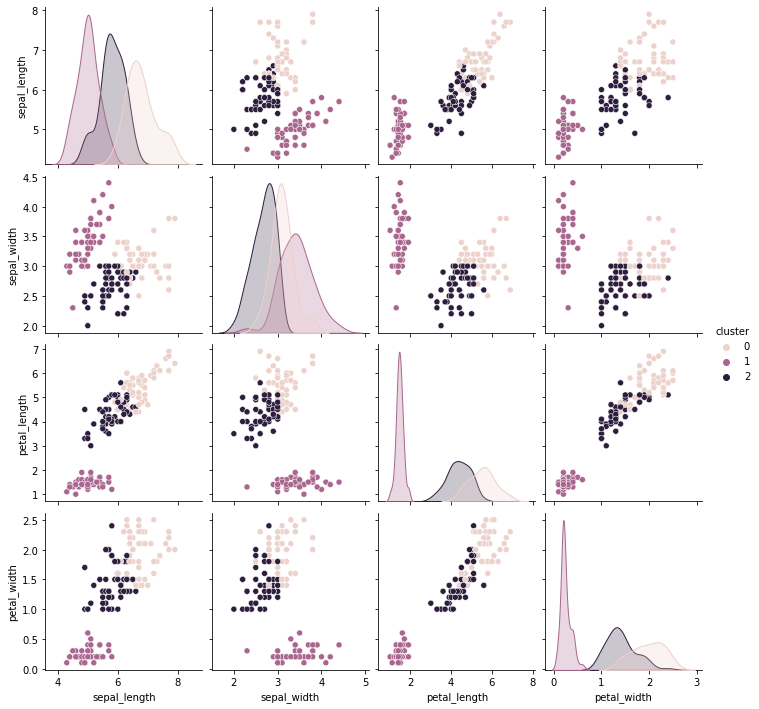

In [17]:
# Visualizamos los resultados
X_iris['cluster'] = y_km
sns.pairplot(X_iris, hue='cluster');

Comparando los dos _pair plot_ que hemos graficado, podemos observar que la segmentación de flores resultante del análisis de _clustering_ guarda una estrecha relación con las etiquetas reales, incluso aunque K-Means jamás las observó durante el ajute a los datos.

Esto significa que aun sin un experto que nos indique las etiquetas de las flores individuales, las _features_ de estas observaciones son lo suficientemente distintivas para que podamos identificar *automáticamente* las diferentes especies con un simple algoritmo de _clustering_.

<a id="section_pca"></a>

### Reducción de la dimensionalidad

[volver a TOC](#section_toc)


Las técnicas de reducción de la dimensionalidad buscan obtener a partir de un dataset complejo, con numerosas variables (alta dimensionalidad), una representación en una menor cantidad de variables (baja dimensionalidad) que de alguna manera preserve cualidades relevantes del dataset original. 

Estas técnicas son muy utilizadas en la etapa de análisis exploratorio de los datos para poder generar visualizaciones interesantes de todas las variables en tan sólo dos o tres dimensiones. También, muchas veces se las utiliza como parte del preprocesamiento de los datos, de forma de obtener nuevas _features_ que alimenten a otro tipo de algoritmos supervisados o no supervisados.

Como un ejemplo de un problema de aprendizaje no supervisado, veamos cómo reducir la dimensionalidad de los datos del dataset Iris para poder visualizarlos más fácilmente.

Como hemos visto, el dataset consta de 150 muestras de 3 especies de la flor Iris, de las cuales disponemos de 4 atributos: el largo y ancho del pétalo y del sépalo.

Por lo tanto, el dataset Iris es cuatridimensional: hay 4 _features_ medidas para cada observación (*sample*).

La tarea de reducción de la dimensionalidad es investigar si hay una representación apropiada de baja dimensionalidad que retiene las características esenciales de los datos originales. 

En este ejemplo, vamos a usar **Principal Component Analysis (PCA)**, una técnica rápida de reducción lineal de la dimensionalidad. Cada componente obtenido es una combinación lineal de todas las variables, donde algunas tienen mayor peso que otras según el caso.

Siguiendo la secuencia de pasos presentada previamente, tenemos:

##### **1. Seleccionamos una clase de modelo**

PCA trabaja con métodos de descomposición de matrices, de ahí que se encuentre en el módulo [`decomposition`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.decomposition) de Scikit-Learn.

In [18]:
from sklearn.decomposition import PCA  

##### **2. Elegir los hiperparámetros del modelo**

Vamos a pedirle al modelo que devuelva dos componentes, es decir, una representación bidimensional de los datos originales.

In [19]:
model = PCA(n_components=2)            

##### **3. Preparar los datos en una matriz de _features_**

Como PCA requiere un preprocesamiento similar a K-Means, en este punto podemos reutilizar nuestra matriz X anteriormente definida.

In [20]:
X[:5]

array([[-0.90068117,  1.01900435, -1.34022653, -1.3154443 ],
       [-1.14301691, -0.13197948, -1.34022653, -1.3154443 ],
       [-1.38535265,  0.32841405, -1.39706395, -1.3154443 ],
       [-1.50652052,  0.09821729, -1.2833891 , -1.3154443 ],
       [-1.02184904,  1.24920112, -1.34022653, -1.3154443 ]])

##### **4. Ajustar el modelo a los datos**

In [21]:
model.fit(X)       

PCA(n_components=2)

##### **5. Predecir etiquetas**

En este caso, la predicción consiste en generar los componentes principales a partir de las variables originales. Al igual que en el caso de `StandardScaler`, cuando trabajamos con modelos de reducción de la dimensionalidad, esto se logra con el método `transform()`:

In [22]:
X_2D = model.transform(X)
X_2D[:5]

array([[-2.26470281,  0.4800266 ],
       [-2.08096115, -0.67413356],
       [-2.36422905, -0.34190802],
       [-2.29938422, -0.59739451],
       [-2.38984217,  0.64683538]])

Ahora vamos a plotear los resultados. Una forma rápida de hacer esto es insertar los resultados en el ``DataFrame`` original de Iris, y usar el método ``lmplot`` de Seaborn para mostrar los resultados:


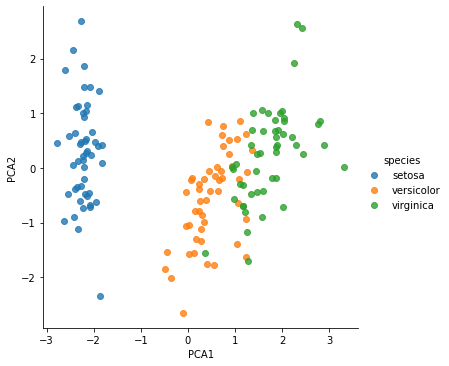

In [23]:
iris['PCA1'] = X_2D[:, 0]
iris['PCA2'] = X_2D[:, 1]
sns.lmplot(x="PCA1", y="PCA2", hue='species', data=iris, fit_reg=False);

Vemos que en la representación en dos dimensiones, las especies están relativamente bien separadas... ¡incluso aunque el algoritmo PCA no tenía conocimiento de las etiquetas de las especies de flores!

Esto significa que es posible condensar la información de las cuatro _features_ originales en dos variables nuevas que se construyen a partir de todas ellas y que buscan preservar la esencia de la información que están condensando.

<a id="section_resumen"></a>

### En Resumen

[volver a TOC](#section_toc)


Hemos tenido nuestro primer contacto con aplicaciones de _machine learning_ no supervisado con Scikit-Learn. Este tipo de aprendizaje se caracteriza por la ausencia de una variable objetivo. El objetivo del aprendizaje no supervisado consiste en descubrir patrones o estructuras subyacentes en la información que nos permitan **segmentar las observaciones (_clustering_) o generar representaciones de los datos en una menor dimensionalidad**. 

A esta altura, ya hemos cubierto a grandes rasgos los distintos tipos de aprendizajes posibles, las características esenciales de la representación de datos y el flujo de trabajo típico de Scikit-Learn.

Sin importar el tipo de estimador, el mismo patrón de importar-instanciar-ajustar-predecir se mantiene en todos los casos, aunque con algunas diferencias que van a depender del tipo de problema con el que estemos trabajando.

Con estas nuevas herramientas, ya podés explorar la documentación de Scikit-Learn y comenzar a probar varios modelos sobre tus datos, teniendo siempre presente qué tipo de pregunta deseás responder:

<div id="caja10" style="float:left;width: 100%;">
  <div style="float:left;width: 15%;"><img src="../../../common/icons/ponete_a_prueba.png" style="align:left"/> </div>
  <div style="float:left;width: 85%;"><label><b>- ¿Tengo una variable objetivo o pretendo hallar estructuras suyacentes en los datos para enriquecer el análisis?<br/>
- ¿Quiero predecir un valor continuo o categórico?<br/>
- ¿Deseo segmentar las observaciones?<br/>
- ¿Cómo puedo generar visualizaciones que condensen la esencia de los datos?</b></label></div>
</div>